In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as sco

In [2]:
path = '/home/PedroSci/Documents/RegistroClima/PortfolioSelection/dataAdjClose.csv'
stocks = ['KO',	'NFLX',	'TSLA']
num_portfolios = 500
risk_free_rate = 0.0178

In [3]:
def load_DB(path:str):
    'load a csv database'
    data = pd.read_csv(filepath_or_buffer=path)
    return data

In [4]:
def createDataset(path:str, stocks:list):
    df_complete = load_DB(path=path)  
    df_complete['Date'] = pd.to_datetime(df_complete['Date']) #change str to datetime Date column
    df_complete= df_complete.set_index('Date') # return the date column as index
    filter_df   = df_complete[stocks] # filter about assets list 
    table =  filter_df.dropna() #drop NA records
    return table

In [5]:
# df_complete = load_DB(path=path)  
# df_complete['Date'] = pd.to_datetime(df_complete['Date']) #change str to datetime Date column
# df_complete= df_complete.set_index('Date') # return the date column as index
# filter_df   = df_complete[stocks] # filter about assets list 
# table =  filter_df.dropna() #drop NA records
table = createDataset(path=path, stocks=stocks)
table

,KO,NFLX,TSLA
Date,,,
2010-06-29,16.594770,16.082857,1.592667
2010-06-30,16.525530,15.521429,1.588667
2010-07-01,16.495853,15.665714,1.464000
2010-07-02,16.502451,15.297143,1.280000
2010-07-06,16.627743,15.324286,1.074000
...,...,...,...
2024-02-22,61.150002,588.469971,197.410004
2024-02-23,61.200001,583.559998,191.970001
2024-02-26,60.709999,587.650024,199.399994


In [6]:
def table_retusns_cov(table):
    returns = table.pct_change()
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    return returns, mean_returns, cov_matrix

Text(0, 0.5, 'price in $')

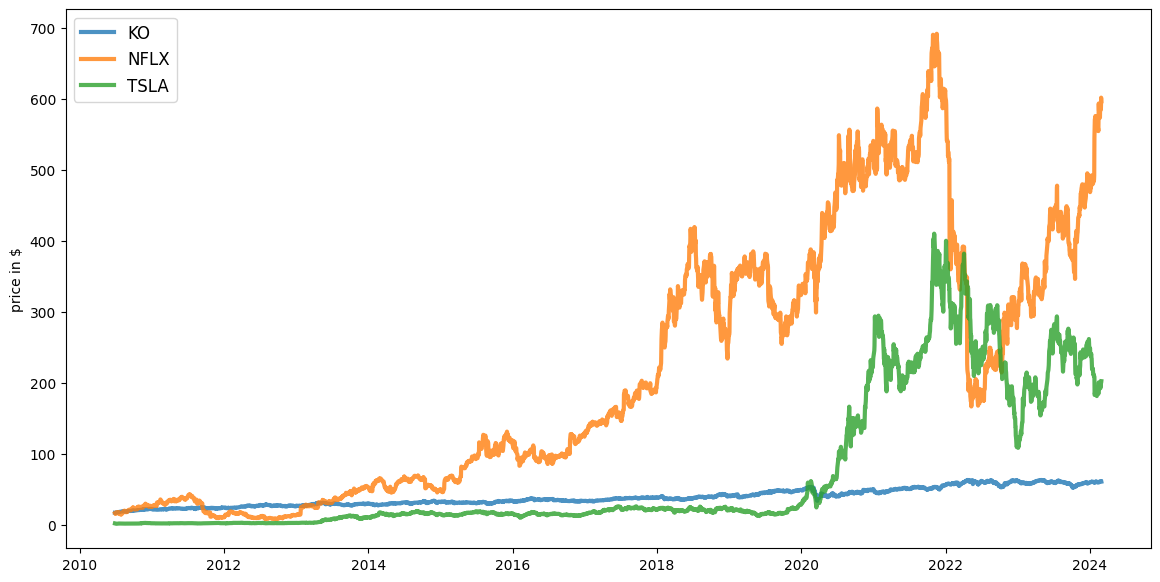

In [7]:
plt.figure(figsize=(14,7))
for c in table.columns.values:
    plt.plot(table.index, table[c], lw=3,alpha=0.8, label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')

calcularemos la tabla con las diferencias log

Text(0, 0.5, 'price in $')

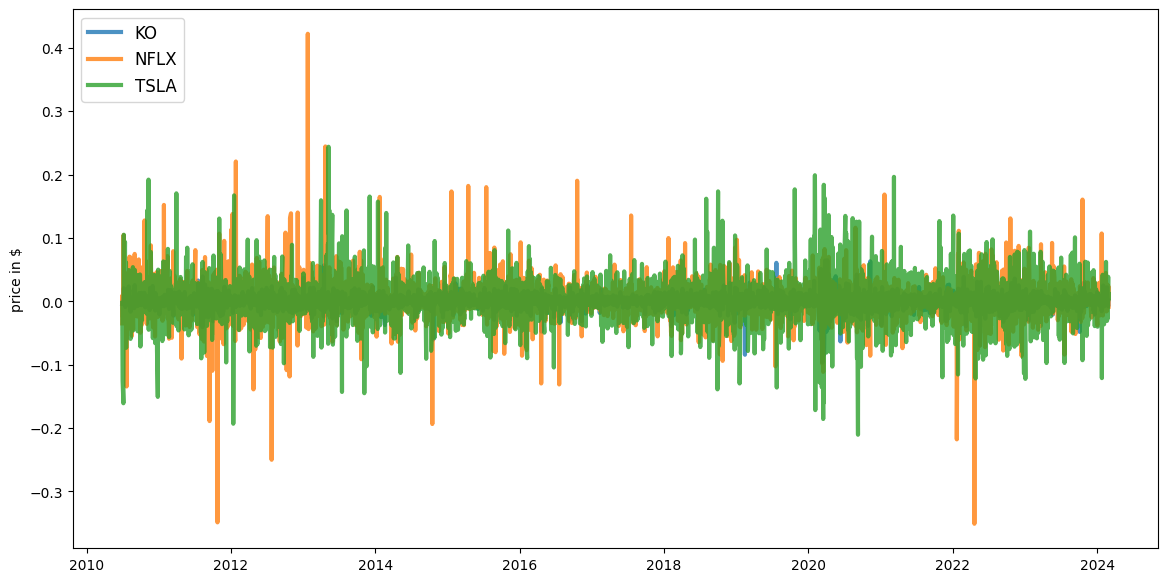

In [8]:
returns = table.pct_change()

plt.figure(figsize=(14,7))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=3,alpha=0.8, label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')

In [9]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights)*252  #252 dias habiles en la bolsa
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

In [10]:
def random_portfolios(n_companies:int, num_portfolios:int, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(n_companies)
        weights /= np.sum(weights)
        weights_record.append(weights)

        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights=weights, mean_returns=mean_returns,cov_matrix=cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return-risk_free_rate) / portfolio_std_dev
    
    return results, weights_record

In [24]:
def display_simulated_ef_with_random(n_companies:int, mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(n_companies=n_companies, num_portfolios=num_portfolios, mean_returns=mean_returns, cov_matrix=cov_matrix, risk_free_rate=risk_free_rate)

    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0, max_sharpe_idx], results[1, max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx], index=table.columns, columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2) for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    min_sharpe_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0, min_sharpe_idx], results[1, min_sharpe_idx]
    min_vol_allocation = pd.DataFrame(weights[min_sharpe_idx], index=table.columns, columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2) for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T

    print('-'*40)
    print('max sharpe ratio portfolio allocation\n')
    print('anual return', round(rp,2))
    print('anual volatilidad', round(sdp,2))
    print('\n')
    print(max_sharpe_allocation)
    print('-'*40)
    print('min volatility portfolio allocation\n')
    print('anual return', round(rp_min,2))
    print('anual volatilidad', round(sdp_min,2))
    print('\n')

    plt.figure(figsize=(10,7))
    plt.scatter(results[0,:], results[1,:], cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp, marker='*', color='r', s=500, label='Max sharpe ratio')
    plt.scatter(sdp_min,rp_min, marker='*', color='g', s=500, label='min volatility')
    plt.title('Simulacion de portafolio optimo   basado en la frontera efficeinte')
    plt.xlabel('volatilidad anual')
    plt.ylabel('retorno anualizado')
    plt.legend(labelspacing=0.8)

    print(results, weights)


----------------------------------------
max sharpe ratio portfolio allocation

anual return 0.26
anual volatilidad 0.27


              KO   NFLX  TSLA  BABA    KO
allocation  39.6  35.09  24.7  0.06  0.55
----------------------------------------
min volatility portfolio allocation

anual return 0.1
anual volatilidad 0.17


[[0.29258405 0.1736442  0.27471252 ... 0.23022452 0.28087707 0.32150023]
 [0.2528202  0.1130793  0.23764611 ... 0.16964046 0.20174052 0.14502792]
 [0.86375249 0.65063676 0.86470799 ... 0.73641357 0.71789599 0.45078638]] 

/tmp/ipykernel_10142/1117401015.py:29: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(results[0,:], results[1,:], cmap='YlGnBu', marker='o', s=10, alpha=0.3)


[array([0.08996556, 0.34897696, 0.25148894, 0.17668301, 0.13288553]), array([0.55675481, 0.07821146, 0.02924834, 0.1089745 , 0.22681088]), array([0.22910486, 0.32440651, 0.22392653, 0.17257971, 0.04998239]), array([0.32834679, 0.34560821, 0.22848937, 0.03178416, 0.06577146]), array([0.18961126, 0.15305017, 0.24896866, 0.2639883 , 0.14438162]), array([0.25805904, 0.12858217, 0.13492849, 0.24388487, 0.23454542]), array([0.35630936, 0.16331467, 0.01756571, 0.13543497, 0.32737529]), array([0.46958411, 0.07899153, 0.09569254, 0.2472758 , 0.10845601]), array([0.12906958, 0.13519888, 0.18548516, 0.27942275, 0.27082362]), array([0.24121088, 0.20522967, 0.02980478, 0.15560055, 0.36815411]), array([0.22766158, 0.23688784, 0.30100593, 0.20711264, 0.02733201]), array([0.27044385, 0.24818496, 0.15535243, 0.0341179 , 0.29190086]), array([0.13801971, 0.40907018, 0.08461434, 0.26901001, 0.09928576]), array([0.0752307 , 0.15314377, 0.27035595, 0.35610522, 0.14516437]), array([0.17896028, 0.37997954, 0.

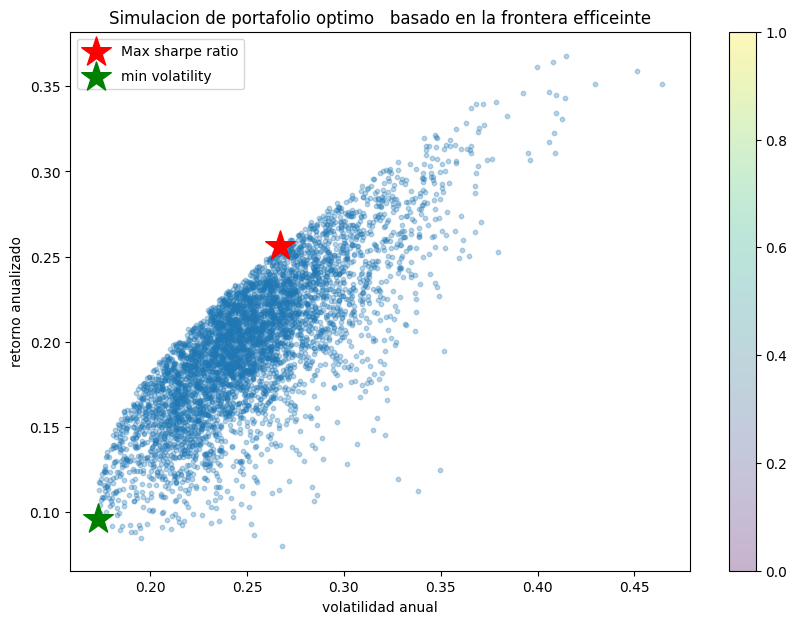

In [30]:
path = '/home/PedroSci/Documents/RegistroClima/PortfolioSelection/dataAdjClose.csv'
stocks = ['KO',	'NFLX',	'TSLA', 'BABA', 'KO']
n_companies = len(stocks)
num_portfolios = 5000
risk_free_rate = 0.0001


table = createDataset(path=path, stocks=stocks)
returns, mean_returns, cov_matrix = table_retusns_cov(table)
display_simulated_ef_with_random(n_companies=n_companies,mean_returns=mean_returns, cov_matrix=cov_matrix, num_portfolios=num_portfolios, risk_free_rate=risk_free_rate)

In [13]:
# portfolio_annualised_performance(weights=weights, mean_returns=mean_returns,cov_matrix=cov_matrix)

# results, weights = random_portfolios(num_portfolios=num_portfolios, mean_returns=mean_returns, cov_matrix=cov_matrix, risk_free_rate=risk_free_rate)


In [14]:
returns, mean_returns, cov_matrix = table_retusns_cov(table)
weights = np.random.random(3)
weights /= np.sum(weights)
returns = np.sum(mean_returns*weights)*252  #252 dias habiles en la bolsa
# std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
mean_returns

KO      0.000435
NFLX    0.001562
TSLA    0.002046
dtype: float64

In [15]:
returns = table.pct_change()
mean_returns = returns.mean()
type(mean_returns)

pandas.core.series.Series